In [1]:
!pip install ds-box

     |████████████████████████████████| 143kB 8.6MB/s 


# LSTM and CNN for text classification
## Sentiment analysis applied to tweets in French

Data from the DEFT'2017 academic competition: https://deft.limsi.fr/2017/

Notebook and DSbox lib packaged by [V. Levorato](https://www.linkedin.com/in/vlevorato/).<br/>
GitHub: https://github.com/vlevorato/dsbox


In [0]:
import pandas as pd
pd.set_option("max_colwidth", 150)

In [0]:
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (10.0, 8.0)

## Data import
We take the dataset concerning figurative tweets. The aim here is to detect whether a tweet uses figurative language or not. We are interested in three phenomena: irony, sarcasm and humor. If a tweet contains at least one expression related to these phenomena, it is considered figurative, otherwise it is considered non-figurative.

In [0]:
url = 'https://github.com/vlevorato/dsbox/files/4624306/task2-train.csv.gz'
X = pd.read_csv(url,skiprows=10, sep='\t', header=None, encoding='utf-8', quoting=3)
X.columns = ['id','text','class']
X = X.set_index('id')
X = X.reset_index(drop=True)

In [9]:
X.head(5)

,text,class
0,Train de vie des ministères : Fillon conteste les chiffres http://tinyurl.com/y89zgkk Qui ment? (),figurative
1,Un complot sioniste pour augmenter les accidents mortels en Tunisie http://snipr.com/ua2dw,figurative
2,[rp-fr][Numerama] La Chine rejoint l'Inde pour s'opposer à l'ACTA http://ur1.ca/05rxl,figurative
3,LeGvnt maitrise la situation RT @cedricgarrofe Incendies en Russie: état d'urgence autour d'un centre nucléaire http://bit.ly/doqgSq,figurative
4,Chanceux! RT @lemondefr Le patron de Google reçu par Nicolas Sarkozy http://bit.ly/aYrNCx,figurative


### Target build

In [0]:
X['class_cat'] = X['class'].map(lambda x : 1 if x == 'figurative' else 0)

### Cleansing
Quick text clean up, and we replace all the URLs with the same keyword.

In [0]:
import re

def parse_tweet(text):
    text = text.replace('@', '')
    text = text.replace('#', '')
    text = text.replace('\n', '')
    text = text.replace('\r','')
    
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    for url in urls:
        text = text.replace(url,'url')

    return text

In [0]:
X['text'] = X['text'].map(lambda x : parse_tweet(x))

We remove the punctuation and we pass everything in lowercase. It is not necessarily a good idea to remove all punctuation in the case of a sentiment analysis problem, but that will do the trick for this tutorial.

In [0]:
import string

def remove_punct(text):
    for p in string.punctuation:
        text = text.replace(p, ' ')
    text = ' '.join(text.split())
    return text

In [0]:
X['text'] = X['text'].map(lambda x: remove_punct(x).lower())

Final dataset:

In [15]:
X.sample(5)

,text,class,class_cat
418,gonflée mme photoshop adjani ne va pas imiter annesinclair dans le film sur l affaire dsk je ne vais pas prendre 10kg,nonfigurative,0
1363,hollande aux états unis ridiculous url lepointdepuis berlusconi aucun chef d état n a été aussi ridicule,nonfigurative,0
2770,j ai vu la pub de dvd fast and furious 7 ça m a donner envie de le voir x1f445 x1f44c x1f3fc,nonfigurative,0
1485,« manuel valls c est candide place beauvau sur les écoutes sur cahuzac il n a jamais rien vu rien entendu » bruno lemaire sur sudradio,nonfigurative,0
2773,quel est le dernier film que tu aies vu — fast and furious 7 url,nonfigurative,0


## Train/test dataset split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X['text'], X['class_cat'], test_size=0.2, random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)

(4682,)
(1171,)


## LSTM pipeline


### Text2Sequence

Once the text has been cleaned, we will perform several steps to transform the data and pass it as input to the neural network:
* **Tokenization**: `comment est votre blanquette` becomes `['comment', 'est', 'votre', 'blanquette']`
* **Stemming**: to reduce vocabulary, we only keep the root of the words. `['comment', 'est', 'votr', 'blanquet']`
* **Corpus dictionary**: we store all stemmed tokens in a dictionary.
* **Token2Id**: each word in the corpus has a unique id, and each sequence of words is transformed into a sequence of ids. `['comment', 'est', 'votr', 'blanquet']` becomes `[14, 3, 36, 23]`.
* **Normalization of the size of the sequences**: a neural network takes a fixed input size, it is therefore necessary to normalize the size of the sequences. Arbitrarily, we choose the average size of the sequences + 2 times the standard deviation. Sequences that are too large will be truncated and sequences that are too small will be * padded *. If `0` is the padding value, with 10 as the fixed sequence size,`[14, 3, 36, 23]` becomes `[0, 0, 0, 0, 0, 0, 14, 3, 36, 23]`

### NN Architectures

In [0]:
from nltk.stem.snowball import FrenchStemmer
from dsbox.ml.neural_networks.processing import Text2Sequence

from dsbox.ml.neural_networks.keras_factory.text_models import LSTMFactory, CNN_LSTMFactory
from dsbox.ml.neural_networks.processing.workflow import TextNeuralNetPipeline

The `LSTMFactory` factory returns a neural network with this architecture:

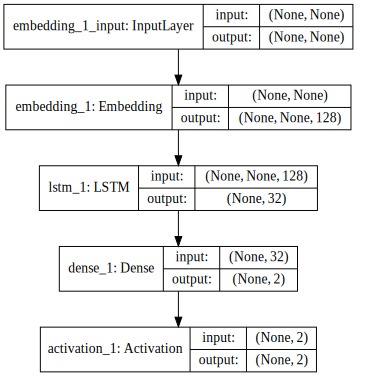

In [19]:
lstm_model = LSTMFactory().create_model(100)
SVG(model_to_dot(lstm_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

The `CNN_LSTMFactory` factory returns a neural network with this architecture:

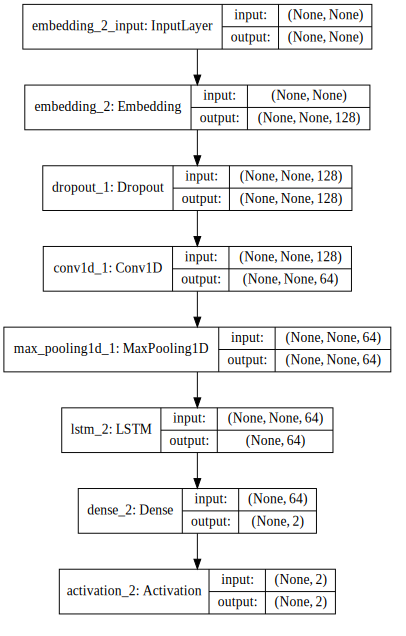

In [20]:
cnn_lstm_model = CNN_LSTMFactory().create_model(100)
SVG(model_to_dot(cnn_lstm_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

### Training

We create the pipeline with the desired factory, and the cardinality of the target. In our case, we will use the simplest factory, the `LSTMFactory`. The `TextNeuralNetPipeline` class is able to preprocess text to transform it into integer sequences, as well as fit / predict.

In [0]:
model = TextNeuralNetPipeline(text2seq=Text2Sequence(stemmer=FrenchStemmer()), 
                              factory_class=LSTMFactory, 
                              num_labels=2)

In [22]:
model.fit(X_train, y_train, 
                        epochs=5,
                        batch_size=100,
                        shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
4682/4682 [==============================] - 3s 592us/step - loss: 0.6250 - accuracy: 0.6589
Epoch 2/5
4682/4682 [==============================] - 2s 448us/step - loss: 0.4485 - accuracy: 0.7832
Epoch 3/5
4682/4682 [==============================] - 2s 442us/step - loss: 0.2364 - accuracy: 0.9156
Epoch 4/5
4682/4682 [==============================] - 2s 442us/step - loss: 0.1188 - accuracy: 0.9590
Epoch 5/5
4682/4682 [==============================] - 2s 447us/step - loss: 0.0574 - accuracy: 0.9842


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TextNeuralNetPipeline(factory_class=None, num_labels=2, random_state=42,
                      text2seq=Text2Sequence(pad_string='',
                                             stemmer=<FrenchStemmer>,
                                             tokenizer=<nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7f00dca23a20>))

### Test and metrics

In [0]:
from sklearn import metrics

In [0]:
y_pred = model.predict(X_test)

In [0]:
average = 'binary'
precision_score = metrics.precision_score(y_test, y_pred, average=average)
recall_score = metrics.recall_score(y_test, y_pred, average=average)
f_score = metrics.f1_score(y_test, y_pred, average=average)

In [26]:
print("Precision : " + str(precision_score))
print("Recall : " + str(recall_score))
print("F-Score : " + str(f_score))

Precision : 0.6731301939058172
Recall : 0.6394736842105263
F-Score : 0.6558704453441295


In [0]:
y_pred_proba = model.predict_proba(X_test)

In [0]:
from dsbox.ml.visualization.metrics import plot_roc_curve

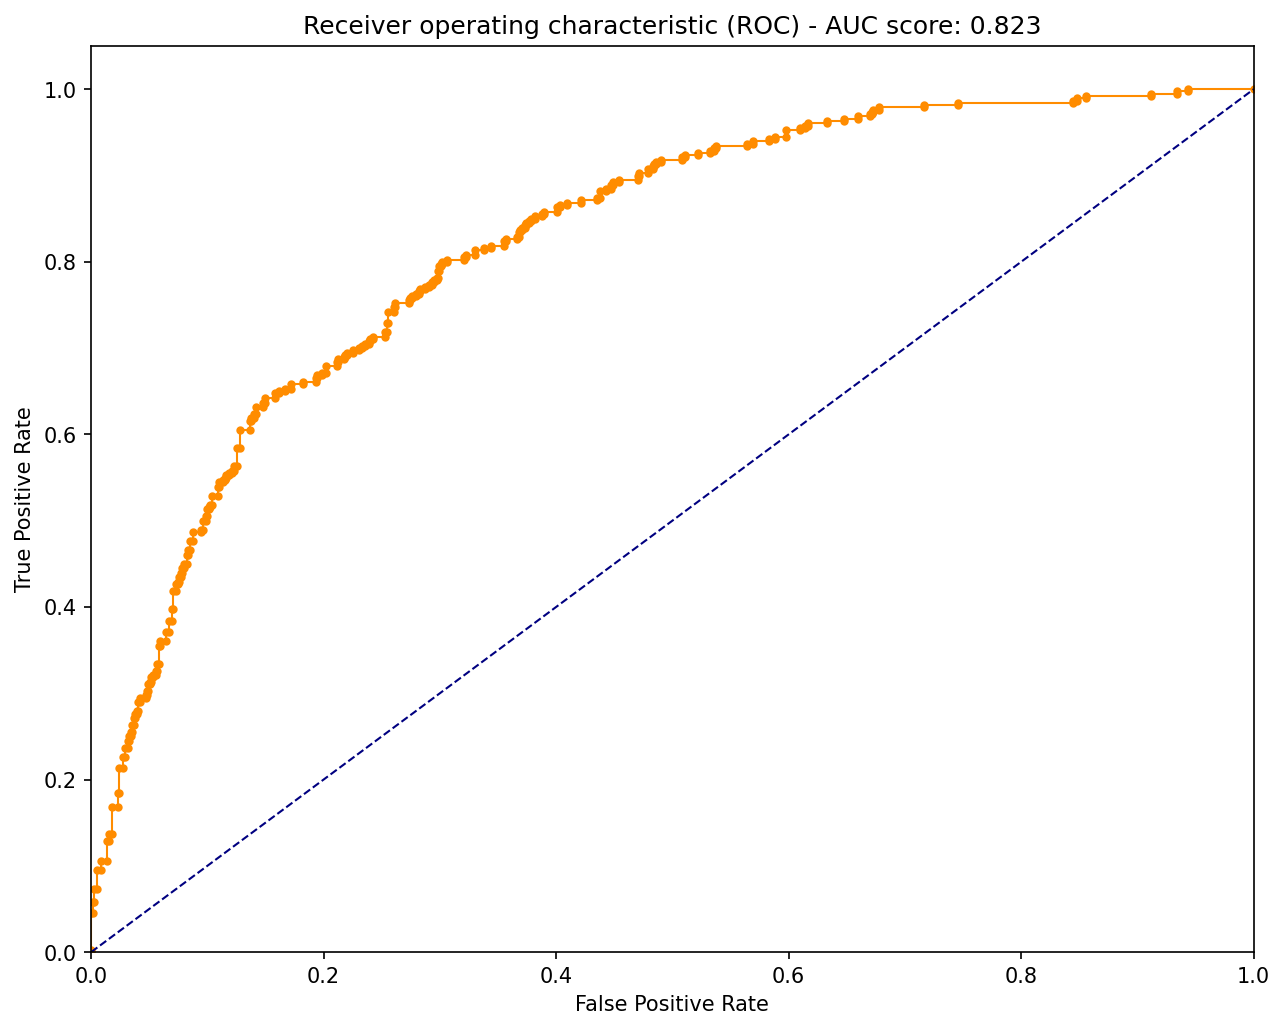

In [32]:
plot_roc_curve(y_test, y_pred_proba)

## Cross validation
Having a complete pipeline is nice, however, you may need to redecompose this pipeline to cut it into smaller processes (Airflow for instance) or to perform cross validation. Here, we will only transform the text into sequences once and this is the model that we will launch several times.

Code sample from `fit` method taken from `TextNeuralNetPipeline` class:

```python
x = self.text2seq.fit_transform(X)
y_enc = np_utils.to_categorical(y, self.num_labels)

self.model_ = KerasClassifier(build_fn=self.factory.create_model,
                              dictionary_size=self.text2seq.dictionary_size_,
                              num_labels=self.num_labels)

self.model_.fit(x, y_enc, **kwargs)
```

We need to decompose the process, with a `Text2Sequence` object on one side and a `KerasClassifier` on the other side.

In [0]:
from dsbox.ml.neural_networks.processing import Text2Sequence

text2seq = Text2Sequence()
x = text2seq.fit_transform(X['text'])
y = X['class_cat']

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier

clf_keras = KerasClassifier(build_fn=LSTMFactory().create_model,
                              dictionary_size=text2seq.dictionary_size_,
                              num_labels=2,
                              epochs=5,
                              batch_size=100, 
                              verbose=0)

We are now able to perform the cross validation:

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [0]:
%%time
scores = cross_val_score(clf_keras, x, y, cv=cv, scoring='roc_auc')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a

CPU times: user 1min 53s, sys: 15.3 s, total: 2min 9s
Wall time: 1min 19s


In [0]:
print(scores)
np.mean(scores)

[0.80769845 0.81194975 0.80706195 0.81038117 0.82059471]


0.8115372058840483

The model seems stable with the AUC score.